In [8]:
# import mudles to be used in this research
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.metrics import accuracy_score
import yfinance as yf
import matplotlib.pyplot as plt
import plotly.graph_objects as go

## Understanding of generating temperal dataset
(Optional; Prerequisite Knowledge)

Before dive in, let's first get some grisp on genearting time series data. 

Recursive models get fed of data in 3-dimentional input data; Batch_size, Sequnece_length and Num_of_fetures.
( In DNN where easily IID assumption can be applied, input data is 2D, Batch_size, Num_of_features ). Conveinently enough Tensorflow comes with a `TimeSeriesGenerator`.

In this session, I will eplore how `TimeSeriesGenerator` generate time-series data, espeically what is target value it returns.

In [9]:
# Generating synthetic data

# Input data
# To help understanding, first column of data starts from 1 to 20 (second column 2 to 21, third 3 to 22)
col1 = np.arange(1, 21, 1)
col2 = np.arange(2, 22, 1)
col3 = np.arange(3, 23, 1)
data = np.column_stack([col1, col2, col3])

# Targets
targets = np.array([i for i in range(1, 21)])

# Look into the synthetic data
print("Print data[:5]")
print(data[:5])

print("Print targets[:5]")
print(targets[:5])


Print data[:5]
[[1 2 3]
 [2 3 4]
 [3 4 5]
 [4 5 6]
 [5 6 7]]
Print targets[:5]
[1 2 3 4 5]


In [10]:
# TimeseriesGenerator
sequence_length=3
# generator = TimeseriesGenerator(data, targets, length=sequence_length, batch_size=2)
generator = TimeseriesGenerator(data, targets, length=sequence_length, batch_size=1)

In [11]:
for i in range(3):
    x, y = generator[i]
    print(f"Batch {i + 1} - Input shape: {x.shape}, Target shape: {y.shape}")
    print("---input---")
    print(x)
    print(f"target - {y}")

print("\n\n") 
print(""" Note that target is n+1
      For instance for row 3~5, target is 6""")

Batch 1 - Input shape: (1, 3, 3), Target shape: (1,)
---input---
[[[1 2 3]
  [2 3 4]
  [3 4 5]]]
target - [4]
Batch 2 - Input shape: (1, 3, 3), Target shape: (1,)
---input---
[[[2 3 4]
  [3 4 5]
  [4 5 6]]]
target - [5]
Batch 3 - Input shape: (1, 3, 3), Target shape: (1,)
---input---
[[[3 4 5]
  [4 5 6]
  [5 6 7]]]
target - [6]



 Note that target is n+1
      For instance for row 3~5, target is 6


Note that the target is in the next row (i+sequence_length), where i is the current row index. This makes sense because, in time series forecasting, we typically predict the next value based on a sequence of past values. For example, with a sequence length of 3, we aim to predict the value at time step i+3 using data from time steps i, i+1, and i+2.

---

# Load Real Stock Data using yfinanc

In [12]:
data = yf.download('MNST', start="2000-01-01", end="2020-01-01")
# Remove 'Close' column and replace it with 'Adj Close'
data.drop(columns=['Close'], inplace=True)
data.rename(columns={'Adj Close': 'Close'}, inplace=True)
pd.concat( [
    data.head(),
    data.tail()
])

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2000-01-03,0.044596,0.046875,0.043620,0.044922,1171200
2000-01-04,0.044922,0.045573,0.042969,0.042969,2438400
2000-01-05,0.044271,0.045573,0.042969,0.042969,1430400
2000-01-06,0.043294,0.044271,0.042969,0.044271,2400000
2000-01-07,0.043294,0.046875,0.042969,0.043294,5251200
2019-12-24,31.764999,31.900000,31.695000,31.735001,1320400
2019-12-26,31.879999,31.965000,31.725000,31.940001,3277000
2019-12-27,31.969999,32.035000,31.740000,31.785000,4530000
2019-12-30,31.709999,31.870001,31.510000,31.680000,3310600


# Add Lags and Prepare Time Series Data

In [13]:
def add_lags(data, lags, window=20):
    cols = []
    df = data.copy()
    df.dropna(inplace=True)
    df['r'] = np.log(df['Close'] / df['Close'].shift(1))
    df['sma'] = df['Close'].rolling(window).mean()
    df['min'] = df['Close'].rolling(window).min()
    df['max'] = df['Close'].rolling(window).max()
    df['mom'] = df['r'].rolling(window).mean()
    df['vol'] = df['r'].rolling(window).std()
    df.dropna(inplace=True)
    df['d'] = np.where(df['r'] > 0, 1, 0)
    features = ['r', 'sma', 'min', 'max', 'mom', 'vol']
    cols += features
    for f in features:
        for lag in range(1, lags + 1):
            col = f'{f}_lag_{lag}'
            df[col] = df[f].shift(lag)
            cols.append(col)
    df.dropna(inplace=True)
    return df, cols

## Split Train & Test dataset

In [14]:
df, cols = add_lags(data, lags=5)
split = int(len(df) * 0.8)

From now on, raw data will be suffixed with '_data'.

In [15]:
train_data = df.iloc[:split].copy()
test_data = df.iloc[split:].copy()

Standardize Data for Model Training

In [16]:
mu, std = train_data.mean(), train_data.std()
train = (train_data-mu) / std
test = (test_data - mu) / std

In [17]:
# Generate time series Data
lags=5
df_ts = TimeseriesGenerator(train[cols], train['r'], length=lags, batch_size=32)

In [18]:
# Data-preview
train.head()

,Open,High,Low,Close,Volume,r,sma,min,max,mom,...,mom_lag_1,mom_lag_2,mom_lag_3,mom_lag_4,mom_lag_5,vol_lag_1,vol_lag_2,vol_lag_3,vol_lag_4,vol_lag_5
Date,,,,,,,,,,,,,,,,,,,,,
2000-02-08,-0.795816,-0.798134,-0.793908,-0.796213,-0.528938,-1.149231,-0.796717,-0.785528,-0.806178,0.040986,...,0.383550,-0.020595,0.218038,0.387359,-0.024582,-0.061908,-0.063524,-0.015847,-0.053548,0.081447
2000-02-09,-0.796001,-0.798265,-0.793908,-0.796161,-0.499958,0.174961,-0.796717,-0.785528,-0.806178,-0.252019,...,0.040680,0.383396,-0.020854,0.217771,0.387240,0.027930,-0.062137,-0.063766,-0.016059,-0.053822
2000-02-10,-0.796106,-0.798265,-0.793961,-0.796372,-0.515122,-0.951118,-0.796711,-0.785528,-0.806178,-0.133490,...,-0.252345,0.040502,0.383167,-0.021132,0.217645,-0.084879,0.027711,-0.062378,-0.063983,-0.016329
2000-02-11,-0.796159,-0.798265,-0.793961,-0.796266,-0.555223,0.405964,-0.796701,-0.785416,-0.806178,-0.016692,...,-0.133809,-0.252544,0.040247,0.382908,-0.021267,-0.156616,-0.085111,0.027480,-0.062595,-0.064258
2000-02-14,-0.796080,-0.798369,-0.793961,-0.796372,-0.507034,-0.503119,-0.796706,-0.785416,-0.806178,-0.368817,...,-0.017001,-0.133999,-0.252821,0.039972,0.382789,-0.144509,-0.156856,-0.085355,0.027272,-0.062871


# Build and Train LSTM Model for Regression

In [19]:
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-4)

In [20]:
#For educational purposes, I have left commented lines that will be used for the classification model
model = Sequential([
    LSTM(128, activation='relu', input_shape=((lags, len(cols))), return_sequences=True),
    LSTM(64, activation='relu'),
    # Dense(1, activation='sigmoid') -> This is not classification
    Dense(1, activation='linear')
]
)
# model.compile(loss='binary_crossentropy', -> This is not classifcation
model.compile(loss='mse',
              optimizer=optimizer, 
            #   metrics=['accuracy']) # No need accuracy in 'mse' loss function
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 128)            84480     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 133953 (523.25 KB)
Trainable params: 133953 (523.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
#TODO
# a function for a model configuration
# why LSTM over simpleRNN

In [15]:
#Train it
model.fit(df_ts, epochs=100, shuffle=False)

Epoch 1/100


/opt/homebrew/Caskroom/miniconda/base/envs/trading-bot/lib/python3.11/site-packages/keras/src/preprocessing/sequence.py:189: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  targets = np.array([self.targets[row] for row in rows])


125/125 [==============================] - 1s 5ms/step - loss: 1.0036
Epoch 2/100
125/125 [==============================] - 1s 5ms/step - loss: 1.0000
Epoch 3/100
125/125 [==============================] - 1s 5ms/step - loss: 0.9982
Epoch 4/100
125/125 [==============================] - 1s 5ms/step - loss: 0.9962
Epoch 5/100
125/125 [==============================] - 1s 5ms/step - loss: 0.9950
Epoch 6/100
125/125 [==============================] - 1s 5ms/step - loss: 0.9936
Epoch 7/100
125/125 [==============================] - 1s 5ms/step - loss: 0.9920
Epoch 8/100
125/125 [==============================] - 1s 5ms/step - loss: 0.9903
Epoch 9/100
125/125 [==============================] - 1s 5ms/step - loss: 0.9885
Epoch 10/100
125/125 [==============================] - 1s 6ms/step - loss: 0.9863
Epoch 11/100
125/125 [==============================] - 1s 5ms/step - loss: 0.9839
Epoch 12/100
125/125 [==============================] - 1s 6ms/step - loss: 0.9810
Epoch 13/100
125/125 [===

---
(Working on) A way to implement split walk-foward in learning.
In a complete honesty, it does not work well, learning not picking up.

I will comeback to it later but it's not major issue as testing on validation is not as important as in classification problem. Setting aside the very recent portion of data for validation or testing would do here.


In [27]:
## Train in validation data.
## + Implementing split_test_data to TimeSeries Dataset.

def train_and_validate(model, generator, epochs=1, verbose=1):
    def _fit():
        for i in range(len(generator) - 1):
            train_data, train_target = generator[i]
            val_data, val_target = generator[i + 1]

            history = model.fit(
                train_data,
                train_target,
                epochs=1,
                validation_data=(val_data, val_target),
                shuffle=False,
                verbose=verbose,
            )

    for e in range(epochs):
        print(f"epoch : {e}")
        _fit()

train_and_validate(model, df_ts, 10)

epoch : 0
1/1 [==============================] - ETA: 0s - loss: 1.5314

1/1 [==============================] - 0s 28ms/step - loss: 0.7173 - val_loss: 0.2421
epoch : 1
1/1 [==============================] - 0s 62ms/step - loss: 0.6814 - val_loss: 0.2579
epoch : 2
1/1 [==============================] - 0s 29ms/step - loss: 0.6812 - val_loss: 0.2392
epoch : 3
1/1 [==============================] - 0s 30ms/step - loss: 0.6945 - val_loss: 0.2489
epoch : 4
1/1 [==============================] - 0s 31ms/step - loss: 0.6737 - val_loss: 0.2428
epoch : 5
1/1 [==============================] - 0s 29ms/step - loss: 0.6801 - val_loss: 0.2250
epoch : 6
1/1 [==============================] - 0s 48ms/step - loss: 0.6783 - val_loss: 0.2820
epoch : 7
1/1 [==============================] - 0s 30ms/step - loss: 0.7185 - val_loss: 0.2593
epoch : 8
1/1 [==============================] - 0s 28ms/step - loss: 0.6836 - val_loss: 0.2750
epoch : 9
1/1 [==============================] - 0s 26ms/step - loss: 0.7030 - val_loss: 0.2502


---

## Test Regression Model on Test Data

In [32]:
df_ts_test = TimeseriesGenerator(test[cols].values, test['r'].values, length=lags, batch_size=16)

### Checking Shape

When using the first 'lags' length to predict lags+1, it's important to adjust the test data by 'lags'.

Additionally, note that the batch size does not result in data overlap between each other.

The dataset generated by TimeSeriesGenerator has a length of num_of_rawdata / batch size, where each batch consists of (X, y=target).

Lastly, each data point (X) comprises information provided during generation, including batch, time sequence, and features.


> 1. Length of raw data: len(test)
> 2. Length of the TimeSeriesGenerator dataset: len(df_ts_test)
> 3. Length of each batch (X, y): len(df_ts_test[0])
> 4. Shape of the first batch's data (X): df_ts_test[0][0].shape


See below for details:

In [33]:
#Length of raw data
len(test)

1002

In [34]:
len(df_ts_test)

63

In [35]:
#legnth of each batch = X, y; 2
len(df_ts_test[0])

2

In [36]:
df_ts_test[0][0].shape

(16, 5, 36)

In [37]:
16*63

1008

# Test on test data set

Note that in the stock market, predicting the exact return value is empirically challenging. Therefore, comparison is based on the direction (sign).

In [38]:
df_ts_test = TimeseriesGenerator(test[cols].values, test['r'].values, length=lags, batch_size=16)
y_hat_regression = model.predict(df_ts_test).flatten()
# By suing accuray_score from sklearn
accuracy_regression = accuracy_score(np.sign(test['r'].iloc[lags:]), np.sign(y_hat_regression))

 1/63 [..............................] - ETA: 7s

63/63 [==============================] - 0s 1ms/step


In [39]:
print(f"Regression Accuracy: {accuracy_regression:.04f}")

Regression Accuracy: 0.5095


# Build and Train LSTM Model for Classification


In [63]:
cls_model = Sequential([
    LSTM(128, activation='relu', input_shape=((lags, len(cols))), return_sequences=True),
    LSTM(64, activation='relu'),
    Dense(1, activation='sigmoid')  # activation is different (linear -> sigmoid) 
]
)

cls_model.compile(optimizer=optimizer, loss='binary_crossentropy', # loss also changed from 'mse' -> 'binary crossentorpy'
                      metrics=['accuracy'])


In [64]:
cls_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 5, 128)            84480     
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 133953 (523.25 KB)
Trainable params: 133953 (523.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [65]:
target = np.where(train['r'] > 0, 1, 0)

In classification, a model may exhibit bias due to imbalances in the sheer number of target data. 

For example, if the dataset comprises 90% of 'a' labels and only 10% of 'b' labels, the model might achieve a seemingly high accuracy of 90% by simply predicting 'a' for all instances, without effectively learning from the features. This underscores the importance of adjusting label weights to address such imbalances and promote meaningful learning from the available features.

In [66]:
def class_weight(a):
    c0, c1 = np.bincount(a)
    w0 = (1 / c0) * (len(a)) / 2
    w1 = (1 / c1) * (len(a)) / 2
    return {0: w0, 1: w1}

In [67]:
df_ts_classification = TimeseriesGenerator(train[cols], target, length=lags, batch_size=32)
cls_model.fit(df_ts_classification, epochs=100, class_weight=class_weight(target))

Epoch 1/100


125/125 [==============================] - 1s 5ms/step - loss: 0.6950 - accuracy: 0.5036
Epoch 2/100
125/125 [==============================] - 1s 5ms/step - loss: 0.6925 - accuracy: 0.5166
Epoch 3/100
125/125 [==============================] - 1s 6ms/step - loss: 0.6915 - accuracy: 0.5194
Epoch 4/100
125/125 [==============================] - 1s 5ms/step - loss: 0.6910 - accuracy: 0.5299
Epoch 5/100
125/125 [==============================] - 1s 6ms/step - loss: 0.6902 - accuracy: 0.5291
Epoch 6/100
125/125 [==============================] - 1s 6ms/step - loss: 0.6897 - accuracy: 0.5336
Epoch 7/100
125/125 [==============================] - 1s 6ms/step - loss: 0.6885 - accuracy: 0.5319
Epoch 8/100
125/125 [==============================] - 1s 6ms/step - loss: 0.6881 - accuracy: 0.5399
Epoch 9/100
125/125 [==============================] - 1s 6ms/step - loss: 0.6878 - accuracy: 0.5376
Epoch 10/100
125/125 [==============================] - 1s 6ms/step - loss: 0.6864 - accuracy: 0.5509
E

# Test Classification Model on Test Data

In [69]:
target_test_classification = np.where(test['r'] > 0, 1, 0)
df_ts_test_classification = TimeseriesGenerator(test[cols], target_test_classification, length=lags, batch_size=16)
y_hat_classification = cls_model.predict(df_ts_test_classification)
y_hat_classification = np.where(y_hat_classification > 0.5, 1, 0)
accuracy_classification = accuracy_score(target_test_classification[lags:], y_hat_classification)

 1/63 [..............................] - ETA: 7s

63/63 [==============================] - 0s 2ms/step


Note that cutoff line is arbituarly set as 0.5 meaning predicted value over cutoff line means stock will go up in the next day. I know it's a bit too crude assumption. In the visualiztion, I will modify this with custom decision values (eg, <.25 go short, >.25 and < .75 do nothing, >.75 go long)

In [70]:
print(f"Classfication Accuracy: {accuracy_classification:.04f}")

Classfication Accuracy: 0.4945


# Visualize Results

In [71]:
# Need raw data(models trained on standardized dataset)
# For visualization we need only return values

df_plot = test_data['r'].copy()
df_plot = pd.DataFrame(df_plot)

In [72]:
df_plot['y_hat'] = np.NaN
df_plot['y_hat'].iloc[lags:] = y_hat_classification.flatten()
pd.concat([df_plot.head(), df_plot.tail()])

,r,y_hat
Date,,
2016-01-08,-0.006564,NaN
2016-01-11,0.012333,NaN
2016-01-12,0.008591,NaN
2016-01-13,-0.024952,NaN
2016-01-14,-0.008739,NaN
2019-12-24,0.001735,0.0
2019-12-26,0.006439,0.0
2019-12-27,-0.004865,0.0
2019-12-30,-0.003309,0.0


First off, let's see very simple implementation.
In this implementation, the strategy takes position all the time flipping direction based on predicted value.
For instance if predicted value is 1, then take long, if not short position

In [73]:
df_plot.dropna(inplace=True)
df_plot['position'] = np.where(df_plot['y_hat'] == 1, 1, -1)
df_plot['strategy'] = df_plot['r'] * df_plot['position']

Note that, 'r' is log return, which mean cumulating and summing up will convert it to have same trajectory as the price movement.

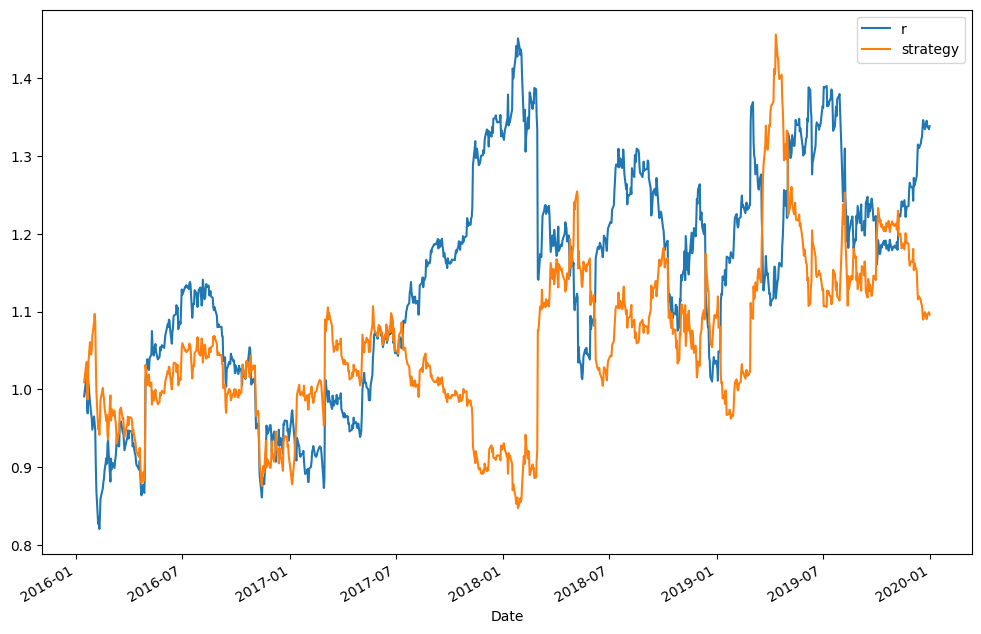

In [74]:
# simple plot (by matplotlib, later I will use plotly for interactive plots)
%matplotlib inline

df_plot[['r', 'strategy']].cumsum().apply(np.exp).plot(figsize=(12,8))
plt.show()

### Shows signals in plots

In [75]:
df_plot['cum_r'] = df_plot['r'].cumsum()

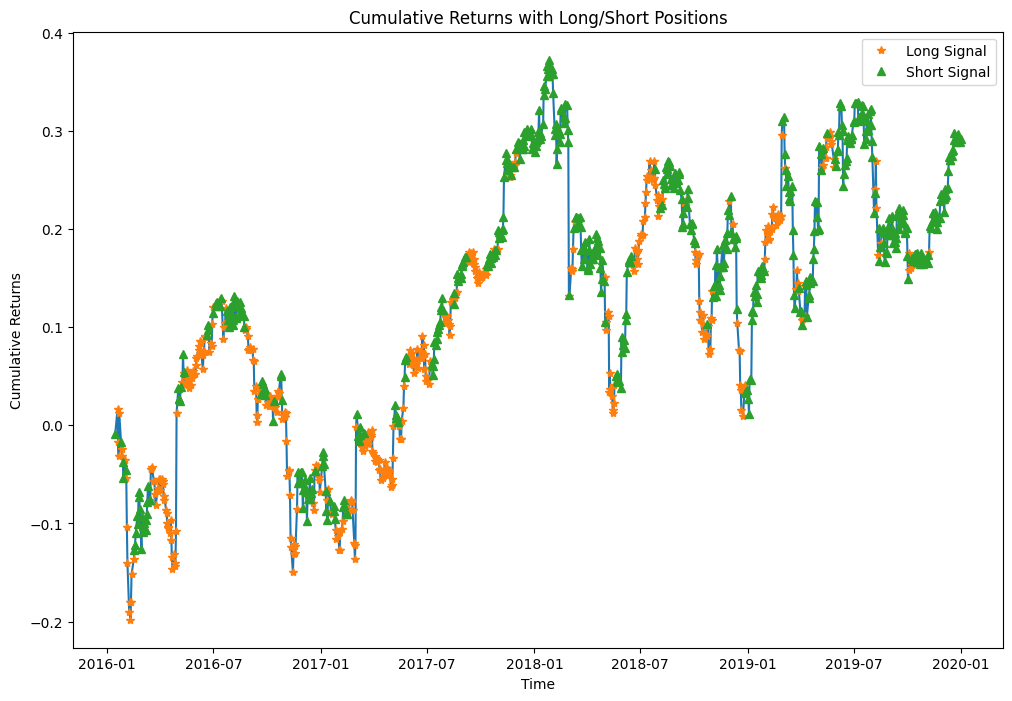

In [76]:
plt.figure(figsize=(12,8))
plt.plot(df_plot['cum_r'])
plt.plot(df_plot[df_plot['position']==1]['cum_r'], '*', label='Long Signal')
plt.plot(df_plot[df_plot['position']==-1]['cum_r'], '^', label='Short Signal')

plt.xlabel('Time')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative Returns with Long/Short Positions')
plt.legend()

plt.show()

# Long Only Strategy and Visualzing Signals

In [77]:
# Custom cutoff line
def func_decision(x):
    if x<0.25: return -1
    elif x>0.75: return 1
    else: return 0


In [78]:
#reset y_hat to make model to buy only when it preidcit over 75% sure and sell 25%
df_plot['y_hat'] = cls_model.predict(df_ts_test)
df_plot['position'] = df_plot['y_hat'].map(func_decision)
df_plot.head()

63/63 [==============================] - 0s 1ms/step


,r,y_hat,position,strategy,cum_r
Date,,,,,
2016-01-15,-0.009099,0.458454,0,0.009099,-0.009099
2016-01-19,0.025396,0.588364,0,0.025396,0.016297
2016-01-20,-0.033292,0.602629,0,-0.033292,-0.016995
2016-01-21,-0.014387,0.777070,1,-0.014387,-0.031382
2016-01-22,0.043525,0.734772,0,0.043525,0.012143


In [79]:
df_plot['position'].value_counts()

position
 0    679
-1    216
 1    102
Name: count, dtype: int64

In [80]:
import plotly.graph_objects as go

fig = go.Figure()

# Plotting 'cum_r'
fig.add_trace(go.Scatter(x=df_plot.index, y=df_plot['cum_r'], mode='lines', name='Cumulative Return'))

# Plotting points for position == 1
fig.add_trace(go.Scatter(x=df_plot[df_plot['position'] == 1].index, y=df_plot[df_plot['position'] == 1]['cum_r'],
                         mode='markers', marker=dict(symbol='star'), name='Position 1'))

# Plotting points for position == -1
fig.add_trace(go.Scatter(x=df_plot[df_plot['position'] == -1].index, y=df_plot[df_plot['position'] == -1]['cum_r'],
                         mode='markers', marker=dict(symbol='triangle-up'), name='Position -1'))

# Layout
fig.update_layout(title='Cumulative Returns with Positions',
                  yaxis_title='Cumulative Returns',
                  showlegend=True,
                  height=600, width=1000)

fig.show()


In [80]:
# TODO: NEXT STEP
# This is a single lumpsum dataset.
# In the next session, I will work on walk-forward optimization, analogous to cross-validation in traditional ML.